In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import census


## Data

In [3]:
key = 'bbca07a4efc2b728095f22d34d04e256444a2bd0'

c = census.Census(key=key, year=2022)

In [4]:
#c.acs5.state_county_blockgroup(fields=('B25078_001E'), state_fips=42, county_fips=3, blockgroup='*', tract='*')
geo = {
    'for': 'block group:*',
    'in': f'state:42 county:003'
}
df = pd.DataFrame(c.acs5.get('B25077_001E', geo=geo))
#df = df.set_index(['state', 'county', 'tract', 'block group'])
#B25077_001E: median value
#B25058_001E: median contract rent
#B25078_001E: VALUE upper quartile
df[df['B25077_001E'] < 0] = np.nan
df = df.rename(axis='columns', mapper={'B25077_001E': 'value_med', 'block group': 'block_group'}).dropna(axis='rows', subset=['value_med'], how='any')
df.head()

,value_med,state,county,tract,block_group
2,166500.0,42,003,010302,2
3,486500.0,42,003,020100,1
4,265400.0,42,003,020100,2
8,430000.0,42,003,020300,1
9,190400.0,42,003,030500,1


In [53]:
ddf = pd.DataFrame(c.acs5.get('B01001_001E', geo=geo))
ddf[ddf['B01001_001E'] < 0] = np.nan
ddf = ddf.rename(axis='columns', mapper={'B01001_001E':'pop', 'block group': 'block_group'})
ddf['GEOID'] = ddf.state+ddf.county+ddf.tract+ddf.block_group
ddf.GEOID = '1500000US' + ddf.GEOID
ddf[ddf.tract.str.startswith('1307')]


,pop,state,county,tract,block_group,GEOID
104,676.0,42,003,130700,1,1500000US420031307001
105,796.0,42,003,130700,2,1500000US420031307002
106,596.0,42,003,130700,3,1500000US420031307003


In [7]:
pd.DataFrame(c.acs5.tables()).query('name == "B25077"').iloc[0].description

'Median Value (Dollars)'

## Shapes

In [37]:
county_subdiv_shape = 'http://www2.census.gov/geo/tiger/TIGER2024/COUSUB/tl_2024_42_cousub.zip'
block_group_shape = 'https://www2.census.gov/geo/tiger/TIGER2024/BG/tl_2024_42_bg.zip'

In [38]:

bg_geo = gpd.read_file(block_group_shape)
cs_geo = gpd.read_file(county_subdiv_shape)

In [39]:
bg_geo.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,42,107,001400,1,421070014001,1500000US421070014001,Block Group 1,G5030,S,49430072,616542,+40.7432609,-076.2456245,"POLYGON ((-76.32707 40.72346, -76.32002 40.728..."
1,42,013,011001,2,420130110012,1500000US420130110012,Block Group 2,G5030,S,23519061,13214,+40.4573201,-078.5107709,"POLYGON ((-78.54356 40.45371, -78.54299 40.454..."
2,42,013,010500,1,420130105001,1500000US420130105001,Block Group 1,G5030,S,27447511,29740,+40.5696189,-078.4361014,"POLYGON ((-78.47905 40.54731, -78.47733 40.549..."
3,42,013,011500,2,420130115002,1500000US420130115002,Block Group 2,G5030,S,18647513,0,+40.3471264,-078.4677293,"POLYGON ((-78.53908 40.34577, -78.53716 40.347..."
4,42,013,011002,2,420130110022,1500000US420130110022,Block Group 2,G5030,S,3256825,0,+40.4634822,-078.4340454,"POLYGON ((-78.45507 40.4713, -78.45501 40.4713..."


In [51]:
ddf.set_index('GEOID')

,pop,state,county,tract,block_group
GEOID,,,,,
1400000US420030103011,2028.0,42,003,010301,1
1400000US420030103021,3806.0,42,003,010302,1
1400000US420030103022,825.0,42,003,010302,2
1400000US420030201001,1967.0,42,003,020100,1
1400000US420030201002,1142.0,42,003,020100,2
...,...,...,...,...,...
1400000US420039811001,0.0,42,003,981100,1
1400000US420039811002,0.0,42,003,981100,2
1400000US420039812001,0.0,42,003,981200,1


In [56]:
bg = bg_geo.join(other=ddf.set_index('GEOID'), on='GEOIDFQ')

## Do ring demographics via intersection and apportionment (area-based)

In [59]:
coords = (40.234334, -79.561656)
cdf = pd.DataFrame(dict(name=['youngwood'], latitude=[coords[0]], longitude=[coords[1]]))

gdf = gpd.GeoDataFrame(cdf, geometry=gpd.points_from_xy(cdf.longitude, cdf.latitude), crs='EPSG:4326')
# consider using:
# gpd.geocode(['address'])
gdb = gpd.GeoSeries.buffer

<Axes: >

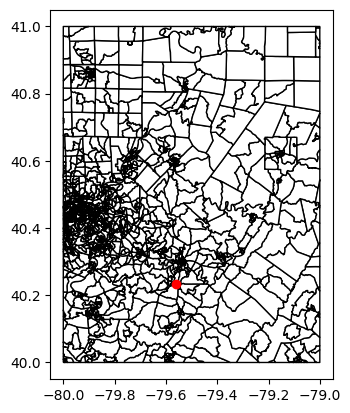

In [67]:
cs_geo[cs_geo.COUNTYFP == '003'].head()

ax = bg.clip([-80,40,-79,41]).plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')

In [72]:
import folium

In [78]:
m = folium.Map(location=[45.523, -122.675],
        zoom_start=2,
        tiles='cartodbpositron',
        attr="Mapbox attribution",
    )

In [ ]:
#folium.GeoJson(bg_geo[bg_geo.COUNTYFP == '003'], name='bg').add_to(m)

In [ ]:
#folium.GeoJson(cs_geo[cs_geo.COUNTYFP == '003'], name='cs').add_to(m)

In [92]:
import branca

colormap = branca.colormap.LinearColormap(
    vmin=cs_geo[cs_geo.COUNTYFP == '003']["ALAND"].quantile(0.0),
    vmax=cs_geo[cs_geo.COUNTYFP == '003']["ALAND"].quantile(1),
    colors=["red", "orange", "lightblue", "green", "darkgreen"],
    caption="Land Area",
)

m = folium.Map(location=[45.523, -122.675],
        zoom_start=2,
        tiles='cartodbpositron',
        attr="Mapbox attribution",
    )

popup = folium.GeoJsonPopup(
    fields=["NAME", "ALAND", "AWATER"],
    aliases=["Name", 'Land', 'Water'],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)
'''
tooltip = folium.GeoJsonTooltip(
    fields=["name", "medianincome", "change"],
    aliases=["State:", "2015 Median Income(USD):", "Median % Change:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)


g = folium.GeoJson(
    statesmerge,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["change"])
        if x["properties"]["change"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip=tooltip,
    popup=popup,
).add_to(m)

colormap.add_to(m)'''

folium.GeoJson(cs_geo[cs_geo.COUNTYFP == '003'], 
               name='cs', 
               popup=popup,
               style_function=lambda x: {
                   'fillColor': colormap(x['properties']['ALAND']) if x['properties'] is not None else 'transparent',
                   'color': 'black',
                   'fillOpacity': 0.4,
               }
    ).add_to(m)

m.fit_bounds(m.get_bounds())
colormap.add_to(m)
m

AssertionError: The field NAME is not available in the data. Choose from: ('STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'GEOIDFQ', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON').